In [13]:
import os
import re
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
from sklearn.model_selection import train_test_split

Обнаружен файл: /home/user/projects/co_hack_fires/train/00/2021-06-06.tiff
File Path: /home/user/projects/co_hack_fires/train/00/2021-06-06.tiff
Driver: GTiff
Width: 215
Height: 222
Count (Bands): 5
CRS: EPSG:4326
Transform: | 10.00, 0.00, 71.47|
| 0.00,-10.00, 56.30|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=71.474895, bottom=-2163.700927, right=2221.474895, top=56.299073)
Datum: ('float32', 'float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 4.0
  Max Value: 23.0
  Mean Value: 12.358684539794922
  Standard Deviation: 3.08229660987854

Band 2:
  Data Type: float32
  Min Value: 5.0
  Max Value: 30.0
  Mean Value: 15.506264686584473
  Standard Deviation: 4.18515682220459

Band 3:
  Data Type: float32
  Min Value: 4.0
  Max Value: 41.0
  Mean Value: 18.802011489868164
  Standard Deviation: 6.582454204559326

Band 4:
  Data Type: float32
  Min Value: 4.0
  Max Value: 76.0
  Mean Value: 34.52409362792969
  Standard Deviation: 11.44923210144043

B

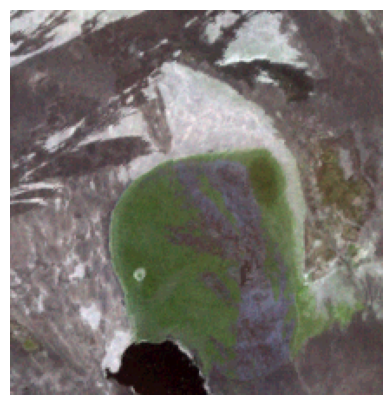

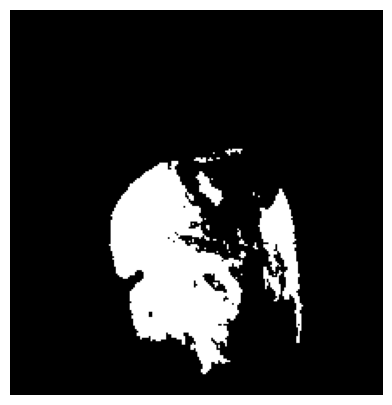

In [103]:
def find_tiff_file(directory):
    """Находит первый .tiff файл в указанной директории с помощью регулярного выражения"""
    tiff_pattern = re.compile(r'.*\.tiff$')  # Регулярное выражение для поиска .tiff файлов
    for file_name in os.listdir(directory):
        if tiff_pattern.match(file_name):
            return os.path.join(directory, file_name)
    raise FileNotFoundError("TIFF файл не найден в указанной директории")

def normalize_band(band):
    """Нормализует данные канала в диапазоне 0-255"""
    band_min, band_max = band.min(), band.max()
    normalized_band = (band - band_min) / (band_max - band_min) * 255.0
    return normalized_band.astype(np.uint8)

def visualize_rgb_geotiff(directory, r_band, g_band, b_band, ik_band, mask_band):
    try:
        # Поиск .tiff файла в указанной папке
        file_path = find_tiff_file(directory)
        print(f"Обнаружен файл: {file_path}")

        with rasterio.open(file_path) as src:

            print(f"File Path: {file_path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")
                
            # Проверка количества доступных каналов
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            if r_band > num_bands or g_band > num_bands or b_band > num_bands or ik_band > num_bands or mask_band > num_bands:
                raise ValueError("Номера каналов превышают количество доступных в файле.")

            # Чтение необходимых каналов
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            # Нормализация каждого канала
            red_norm = normalize_band(red)
            green_norm = normalize_band(green)
            blue_norm = normalize_band(blue)

            # Сборка RGB изображения
            photo_rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1).astype(np.uint8)

            # Обработка маски
            mask_stacked = (mask > 0).astype(np.uint8) * 255  # Преобразование маски в бинарную

            # Определение имени файлов для сохранения
            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Имя файла без расширения
            output_dir = os.path.dirname(file_path)  # Получаем директорию исходного файла
            
            filename = os.path.join(output_dir, f"{base_name}_photo_rgb.jpg")
            filename_mask = os.path.join(output_dir, f"{base_name}_mask.jpg")

            # Сохранение файлов
            cv2.imwrite(filename, photo_rgb)
            cv2.imwrite(filename_mask, mask_stacked)

            # Визуализация изображений
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(photo_rgb)
            ax.axis('off')
            plt.show()

            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(mask_stacked, cmap='gray')
            ax.axis('off')
            plt.show()

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f'Ошибка: {e}')

# Директория с GeoTIFF файлами
directory = '/home/user/projects/co_hack_fires/train/00/'
# Вызов функции для визуализации
visualize_rgb_geotiff(directory, 1, 2, 3, 4, 5)


In [54]:
%pip install segmentation_models.pytorch 

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=3d64d207d790dea2c31a25504a44de5d41162ff83b3d43f9ea8706962edeec87
  Stored in directory: /home/user/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0b8c266e05687edcfa179f5f4687a3de11fec01220ce6ba87f6fa044de47e59a
  Stored in directory: /home/user/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [15]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # имена изображений и масок должны совпадать
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Маска - одноканальное изображение

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [16]:
resize = transforms.Resize((256, 256))

In [17]:
transform_image = transforms.Compose([
    resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
transform_mask = transforms.Compose([
    resize,
    transforms.ToTensor()
])

In [84]:
dataset = SegmentationDataset(
    images_dir='/home/user/projects/co_hack_fires/train/full/train/images/',
    masks_dir='/home/user/projects/co_hack_fires/train/full/train/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [85]:
model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/user/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 47.1M/47.1M [00:01<00:00, 27.6MB/s]


In [91]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [92]:
def pixel_accuracy(outputs, masks):
    outputs = (outputs > 0.5).float()
    correct = (outputs == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()

    intersection = torch.sum((pred * target))

    union = torch.sum(pred) + torch.sum(target) - intersection
    
    if union == 0:
        return torch.tensor(1.0)
        
    iou = intersection / union
    return iou


In [93]:
def split_dataset(dataset, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset, val_split=0.2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1000
for epoch in range(num_epochs):
    # --- ТРЕНИРОВОЧНЫЙ ЦИКЛ ---
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    pixel_acc = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        batch_iou = 0.0
        for i in range(images.size(0)):  # Проходим по каждому изображению в батче
            iou = calculate_iou(outputs[i], masks[i])
            batch_iou += iou.item()
        
        iou_score += batch_iou / images.size(0)

        # Pixel accuracy
        pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = iou_score / len(train_loader)  # IoU на батчах
    epoch_pixel_acc = pixel_acc / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Pixel Accuracy: {epoch_pixel_acc:.4f}")
    
    # --- ВАЛИДАЦИОННЫЙ ЦИКЛ ---
    model.eval()
    val_loss = 0.0
    val_iou_score = 0.0
    val_pixel_acc = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item() * images.size(0)

            batch_iou = 0.0
            for i in range(images.size(0)):  # Проходим по каждому изображению в батче
                iou = calculate_iou(outputs[i], masks[i])
                batch_iou += iou.item()
            
            val_iou_score += batch_iou / images.size(0)

            # Pixel accuracy
            val_pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou_score / len(val_loader)  # IoU на батчах
    epoch_val_pixel_acc = val_pixel_acc / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}, Val Pixel Accuracy: {epoch_val_pixel_acc:.4f}")

Epoch 1/1000, Train Loss: 0.3284, Train IoU: 0.0928, Train Pixel Accuracy: 0.7106
Epoch 1/1000, Val Loss: 0.2349, Val IoU: 0.2639, Val Pixel Accuracy: 0.8010
Epoch 2/1000, Train Loss: 0.3385, Train IoU: 0.1510, Train Pixel Accuracy: 0.7081
Epoch 2/1000, Val Loss: 0.2223, Val IoU: 0.1591, Val Pixel Accuracy: 0.7953
Epoch 3/1000, Train Loss: 0.3010, Train IoU: 0.1453, Train Pixel Accuracy: 0.7139
Epoch 3/1000, Val Loss: 0.2285, Val IoU: 0.1001, Val Pixel Accuracy: 0.7906
Epoch 4/1000, Train Loss: 0.3070, Train IoU: 0.1286, Train Pixel Accuracy: 0.7117
Epoch 4/1000, Val Loss: 0.2225, Val IoU: 0.1622, Val Pixel Accuracy: 0.7960
Epoch 5/1000, Train Loss: 0.2871, Train IoU: 0.1417, Train Pixel Accuracy: 0.7143
Epoch 5/1000, Val Loss: 0.2237, Val IoU: 0.2024, Val Pixel Accuracy: 0.7989
Epoch 6/1000, Train Loss: 0.2877, Train IoU: 0.1062, Train Pixel Accuracy: 0.7141
Epoch 6/1000, Val Loss: 0.2274, Val IoU: 0.2120, Val Pixel Accuracy: 0.7993
Epoch 7/1000, Train Loss: 0.2763, Train IoU: 0.1248,

## valid

215 222


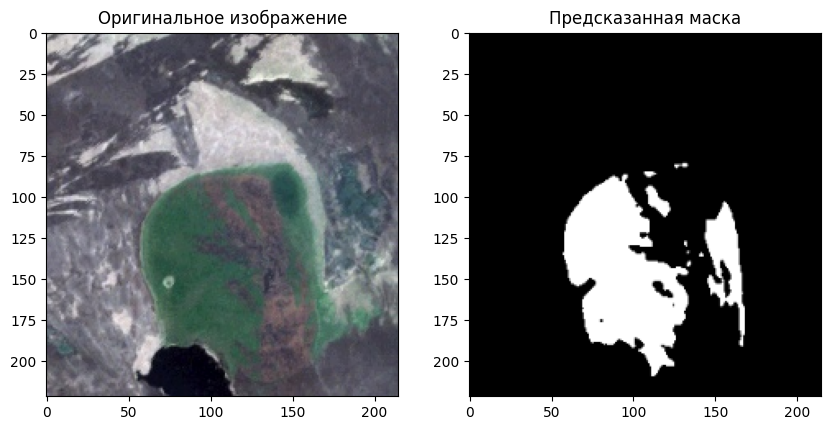

In [98]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, device):
    image = Image.open(image_path).convert('RGB')

    H, W = image.size
    print(H,W)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Изменение размера изображения
        transforms.ToTensor(),          # Преобразование в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
    ])
    
    image = transform(image).unsqueeze(0)  # Добавление batch size
    
    image = image.to(device)
    
    model.eval()
    
    with torch.no_grad():
        # Предсказание
        output = model(image)
    
    pred_mask = output.squeeze().cpu().numpy()  # Извлечение тензора и перевод на CPU
    pred_mask = (pred_mask > 0.05).astype('uint8')  # Бинаризация маски
    pred_mask = pred_mask * 255
    pred_mask = cv2.resize(pred_mask, (H, W)) 
    return pred_mask

# Визуализация оригинального изображения и предсказанной маски
def display_results(image_path, pred_mask):
    image = Image.open(image_path).convert('RGB')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Оригинальное изображение')
    
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Предсказанная маска')
    
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/home/user/projects/co_hack_fires/train/full/train/images/0.jpg"

predicted_mask = predict_image(model, image_path, device)

display_results(image_path, predicted_mask)

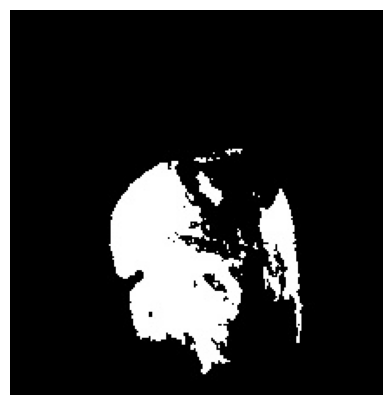

In [99]:
mask_path = "/home/user/projects/co_hack_fires/train/full/train/masks/0.jpg"
mask_orig= Image.open(mask_path).convert('RGB')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(mask_orig)
ax.axis('off')
plt.show()